<a href="https://colab.research.google.com/github/Sara-DaCanal/Progetto-ML/blob/main/progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Progetto di Machine Learning

* Adrian Petru Baba
* Sara Da Canal

### Introduzione

Questo Notebook propone l'analisi di modelli di Machine Learning usati per eseguire una classificazione binaria su un dataset di funghi, per stabilire se sono edibili o velenosi. Inizialmente abbiamo effettuato una fase di preprocessing dei dati, per andare ad ottenere un dataset di qualità, poi siamo andati a testare differenti modelli di machine learning effettuando tuning dei parametri per stabilire quale modello è il migliore per il task considerato.

In [1]:
import pandas as pd
from typing import Tuple
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path_to_dataset = '/content/drive/MyDrive/secondary_data_shuffled.csv'

In [17]:
df = pd.read_csv(path_to_dataset, sep=';')
print(df.columns)
print(df.shape)

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')
(61069, 21)


Abbiamo letto il dataset importandolo come un Dataframe pandas.
Come si può vedere qui sopra, il dataset comprende 21 colonne, di cui 20 sono feature è la prima è il valore target, e 61.069 righe. Di queste colonne, tre hanno valori numerici, mentre tutte le altre presentano valori categorici. Le colonne dei valori categorici sono indicate tramite singole lettere, il che rende il dataset di difficile lettura. In più, anche valori binari sono indicati con le lettere 't' ed 'f' invece che usare 0 e 1. Abbiamo quindi modificato il dataset per renderlo più leggibile. Dopo le modifiche è possibile vedere quante colonne sono categoriche, quante booleane e quante numeriche.

In [18]:
df['cap-shape'].replace(to_replace = 'b', value='bell', inplace=True)
df['cap-shape'].replace(to_replace = 'c', value='conical', inplace=True)
df['cap-shape'].replace(to_replace = 'x', value='convex', inplace=True)
df['cap-shape'].replace(to_replace = 'f', value='flat', inplace=True)
df['cap-shape'].replace(to_replace = 's', value='sunken', inplace=True)
df['cap-shape'].replace(to_replace = 'p', value='spherical', inplace=True)
df['cap-shape'].replace(to_replace = '0', value='other', inplace=True)

df['cap-surface'].replace(to_replace = 'i', value='fibrous', inplace=True)
df['cap-surface'].replace(to_replace = 'g', value='grooves', inplace=True)
df['cap-surface'].replace(to_replace = 'y', value='scaly', inplace=True)
df['cap-surface'].replace(to_replace = 's', value='smooth', inplace=True)
df['cap-surface'].replace(to_replace = 'd', value='dry', inplace=True)
df['cap-surface'].replace(to_replace = 'h', value='shiny', inplace=True)
df['cap-surface'].replace(to_replace = 'l', value='leathery', inplace=True)
df['cap-surface'].replace(to_replace = 'k', value='silky', inplace=True)
df['cap-surface'].replace(to_replace = 't', value='sticky', inplace=True)
df['cap-surface'].replace(to_replace = 'w', value='wrinkled', inplace=True)
df['cap-surface'].replace(to_replace = 'e', value='fleshy', inplace=True)

df['cap-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['cap-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['cap-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['cap-color'].replace(to_replace = 'r', value='green', inplace=True)
df['cap-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['cap-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['cap-color'].replace(to_replace = 'e', value='red', inplace=True)
df['cap-color'].replace(to_replace = 'w', value='white', inplace=True)
df['cap-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['cap-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['cap-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['cap-color'].replace(to_replace = 'k', value='black', inplace=True)

df['does-bruise-or-bleed'].replace(to_replace = 't', value=True, inplace=True)
df['does-bruise-or-bleed'].replace(to_replace = 'f', value=False, inplace=True)

df['gill-attachment'].replace(to_replace = 'a', value='adnate', inplace=True)
df['gill-attachment'].replace(to_replace = 'x', value='adnexed', inplace=True)
df['gill-attachment'].replace(to_replace = 'd', value='decurrent', inplace=True)
df['gill-attachment'].replace(to_replace = 'e', value='free', inplace=True)
df['gill-attachment'].replace(to_replace = 's', value='sinuate', inplace=True)
df['gill-attachment'].replace(to_replace = 'p', value='pores', inplace=True)
df['gill-attachment'].replace(to_replace = 'f', value='none', inplace=True)
df['gill-attachment'].replace(to_replace = '?', value='unknown', inplace=True)

df['gill-spacing'].replace(to_replace = 'c', value='close', inplace=True)
df['gill-spacing'].replace(to_replace = 'd', value='distant', inplace=True)
df['gill-spacing'].replace(to_replace = 'f', value='none', inplace=True)

df['gill-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['gill-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['gill-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['gill-color'].replace(to_replace = 'r', value='green', inplace=True)
df['gill-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['gill-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['gill-color'].replace(to_replace = 'e', value='red', inplace=True)
df['gill-color'].replace(to_replace = 'w', value='white', inplace=True)
df['gill-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['gill-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['gill-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['gill-color'].replace(to_replace = 'k', value='black', inplace=True)
df['gill-color'].replace(to_replace = 'f', value='none', inplace=True)

df['stem-root'].replace(to_replace = 'b', value='bulbous', inplace=True)
df['stem-root'].replace(to_replace = 's', value='swollen', inplace=True)
df['stem-root'].replace(to_replace = 'c', value='club', inplace=True)
df['stem-root'].replace(to_replace = 'u', value='cup', inplace=True)
df['stem-root'].replace(to_replace = 'e', value='equal', inplace=True)
df['stem-root'].replace(to_replace = 'z', value='rhizomorphs', inplace=True)
df['stem-root'].replace(to_replace = 'r', value='rooted', inplace=True)

df['stem-surface'].replace(to_replace = 'i', value='fibrous', inplace=True)
df['stem-surface'].replace(to_replace = 'g', value='grooves', inplace=True)
df['stem-surface'].replace(to_replace = 'y', value='scaly', inplace=True)
df['stem-surface'].replace(to_replace = 's', value='smooth', inplace=True)
df['stem-surface'].replace(to_replace = 'd', value='dry', inplace=True)
df['stem-surface'].replace(to_replace = 'h', value='shiny', inplace=True)
df['stem-surface'].replace(to_replace = 'l', value='leathery', inplace=True)
df['stem-surface'].replace(to_replace = 'k', value='silky', inplace=True)
df['stem-surface'].replace(to_replace = 't', value='sticky', inplace=True)
df['stem-surface'].replace(to_replace = 'w', value='wrinkled', inplace=True)
df['stem-surface'].replace(to_replace = 'e', value='fleshy', inplace=True)
df['stem-surface'].replace(to_replace = 'f', value='none', inplace=True)

df['stem-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['stem-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['stem-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['stem-color'].replace(to_replace = 'r', value='green', inplace=True)
df['stem-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['stem-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['stem-color'].replace(to_replace = 'e', value='red', inplace=True)
df['stem-color'].replace(to_replace = 'w', value='white', inplace=True)
df['stem-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['stem-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['stem-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['stem-color'].replace(to_replace = 'k', value='black', inplace=True)
df['stem-color'].replace(to_replace = 'f', value='none', inplace=True)

df['veil-type'].replace(to_replace = 'p', value=False, inplace=True)
df['veil-type'].replace(to_replace = 'u', value=True, inplace=True)
df['veil-type'].rename("universal-veil")

df['veil-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['veil-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['veil-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['veil-color'].replace(to_replace = 'r', value='green', inplace=True)
df['veil-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['veil-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['veil-color'].replace(to_replace = 'e', value='red', inplace=True)
df['veil-color'].replace(to_replace = 'w', value='white', inplace=True)
df['veil-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['veil-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['veil-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['veil-color'].replace(to_replace = 'k', value='black', inplace=True)
df['veil-color'].replace(to_replace = 'f', value='none', inplace=True)

df['has-ring'].replace(to_replace = 't', value=True, inplace=True)
df['has-ring'].replace(to_replace = 'f', value=False, inplace=True)

df['ring-type'].replace(to_replace = 'c', value='cobwebby', inplace=True)
df['ring-type'].replace(to_replace = 'e', value='evanescent', inplace=True)
df['ring-type'].replace(to_replace = 'r', value='flaring', inplace=True)
df['ring-type'].replace(to_replace = 'g', value='grooved', inplace=True)
df['ring-type'].replace(to_replace = 'l', value='large', inplace=True)
df['ring-type'].replace(to_replace = 'p', value='pendant', inplace=True)
df['ring-type'].replace(to_replace = 's', value='sheathing', inplace=True)
df['ring-type'].replace(to_replace = 'z', value='zone', inplace=True)
df['ring-type'].replace(to_replace = 'y', value='scaly', inplace=True)
df['ring-type'].replace(to_replace = 'm', value='movable', inplace=True)
df['ring-type'].replace(to_replace = 'f', value='none', inplace=True)

df['spore-print-color'].replace(to_replace = 'n', value='brown', inplace=True)
df['spore-print-color'].replace(to_replace = 'b', value='buff', inplace=True)
df['spore-print-color'].replace(to_replace = 'g', value='grey', inplace=True)
df['spore-print-color'].replace(to_replace = 'r', value='green', inplace=True)
df['spore-print-color'].replace(to_replace = 'p', value='pink', inplace=True)
df['spore-print-color'].replace(to_replace = 'u', value='purple', inplace=True)
df['spore-print-color'].replace(to_replace = 'e', value='red', inplace=True)
df['spore-print-color'].replace(to_replace = 'w', value='white', inplace=True)
df['spore-print-color'].replace(to_replace = 'y', value='yellow', inplace=True)
df['spore-print-color'].replace(to_replace = 'l', value='blue', inplace=True)
df['spore-print-color'].replace(to_replace = 'o', value='orange', inplace=True)
df['spore-print-color'].replace(to_replace = 'k', value='black', inplace=True)

df['habitat'].replace(to_replace = 'g', value='grasses', inplace=True)
df['habitat'].replace(to_replace = 'l', value='leaves', inplace=True)
df['habitat'].replace(to_replace = 'm', value='meadows', inplace=True)
df['habitat'].replace(to_replace = 'p', value='paths', inplace=True)
df['habitat'].replace(to_replace = 'h', value='heaths', inplace=True)
df['habitat'].replace(to_replace = 'u', value='urban', inplace=True)
df['habitat'].replace(to_replace = 'w', value='waste', inplace=True)
df['habitat'].replace(to_replace = 'd', value='woods', inplace=True)

df['season'].replace(to_replace = 's', value='spring', inplace=True)
df['season'].replace(to_replace = 'u', value='summer', inplace=True)
df['season'].replace(to_replace = 'w', value='winter', inplace=True)
df['season'].replace(to_replace = 'a', value='autumn', inplace=True)

df['class'].replace(to_replace = 'e', value=True, inplace=True)
df['class'].replace(to_replace = 'p', value=False, inplace=True)

In [19]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()
print("Le feature numeriche sono:" ,numerical_cols)
print("Il numero di feature numeriche è:", len(numerical_cols))
categorical_cols = df.select_dtypes(include='object').columns.to_list()
print("Le feature categoriche sono:" ,categorical_cols)
print("Il numero di feature categoriche è:", len(categorical_cols))
boolean_cols = df.select_dtypes(include='bool').columns.to_list()
print("Le feature booleane sono:" ,boolean_cols)
print("Il numero di feature boolean è:", len(boolean_cols))

Le feature numeriche sono: ['cap-diameter', 'stem-height', 'stem-width']
Il numero di feature numeriche è: 3
Le feature categoriche sono: ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'ring-type', 'spore-print-color', 'habitat', 'season']
Il numero di feature categoriche è: 15
Le feature booleane sono: ['class', 'does-bruise-or-bleed', 'has-ring']
Il numero di feature boolean è: 3


## Preprocessing del dataset
Per andare ad ottenere un dataset coerente siamo andati a verificare la presenza di valori nulli nelle colonne, usando la seguente funzione:

In [20]:
def get_nan_cols(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Index]:
    """ Restituisce:
        0: un dataframe con nome colonna, numero null
        1: una lista (Index) con i nomi delle colonne che hanno valori nulli
    """
    count_nan = dataset.isnull().sum(axis=0)
    columns_with_nan_df = count_nan.loc[count_nan != 0]
    nan_cols_names = dataset.columns[dataset.isna().any()]
    return columns_with_nan_df, nan_cols_names

nan_cols, nan_list = get_nan_cols(df)
print(nan_cols)

cap-surface          14120
gill-attachment       9884
gill-spacing         25063
stem-root            51538
stem-surface         38124
veil-type            57892
veil-color           53656
ring-type             2471
spore-print-color    54715
dtype: int64


Come si può vedere dall'output, abbiamo valori nulli in 9 colonne su 20.

In questa fase abbiamo eliminato dal dataset le colonne relative a feature in cui c'è una percentuale di valori nulli maggiore rispetto a una specifica soglia (nello specifico **75%**).
Possiamo vedere il numero minimo di valori non nulli richiesto per non cancellare la colonna.
Dal numero iniziale, con questa pulizia rimangono solo **14** feature.

In [21]:
righe = df.shape[0]
p = 0.75
def remove_nan_columns(dataset: pd.DataFrame, threshold) -> pd.DataFrame:
    """Elimina colonne con valori NaN quando i valori Nan sono superiori a [threshold]%"""
    thresh = int((len(dataset) * threshold)) + 1
    print("Numero di valori non nulli minimo: ", thresh)
    # axis: specifichiamo di eliminare solo le colonne; thresh: numero minimo per eliminare
    dataset.dropna(axis='columns', thresh=thresh, inplace=True)
    return dataset

new_data = remove_nan_columns(df, p)
print("Il numero di feature ora è:" ,new_data.shape[1])



Numero di valori non nulli minimo:  45802
Il numero di feature ora è: 15


In [22]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()

categorical_cols = df.select_dtypes(include='object').columns.to_list()

boolean_cols = df.select_dtypes(include='bool').columns.to_list()
print('Abbiamo', len(numerical_cols), 'colonne numeriche,', len(categorical_cols), 'colonne categoriche e', len(boolean_cols), 'colonne booleane.')

Abbiamo  3  colonne numeriche,  9  colonne categoriche e  3  colonne booleane.


Di seguito possiamo vedere quali, fra le rimanenti feature, hanno qualche valore nullo (ma non a sufficienza per essere cancellate in base al threshold scelto).
Di fatto, tra le colonne riguardanti feature con valori numerici o booleani, non abbiamo alcun valore null; al contrario, per le feature con valori categorici, abbiamo diversi null.
Nel caso numerico, qualora ce ne fosse stato bisogno, i valori mancanti sarebbero potuti essere riempiti per esempio dalla media del valore di quella feature o con qualche strategia simile.
Nel caso categorico, abbiamo scelto di riempire gli spazi vuoti con la moda del valore della feature corrispondente.

In [23]:
nan_cols, nan_list = get_nan_cols(df)
print(nan_cols)

cap-surface        14120
gill-attachment     9884
ring-type           2471
dtype: int64


Qui di seguito andiamo a calcolare la moda per le colonne considerate, andando anche a mostrare, nei grafici a torta, le distribuzioni percentuali dei diversi valori, in modo da poter visualizzare se la moda copre effettivamente una parte significativa dei valori oppure se ci sono valori che hanno tutti percentuali molto simili tra loro. Come si può vedere, in tutti e tre i casi la moda è molto significativa, quindi la nostra scelta sembra corretta.

La moda per la colonna cap-surface è: sticky
La moda per la colonna gill-attachment è: adnate
La moda per la colonna ring-type è: none


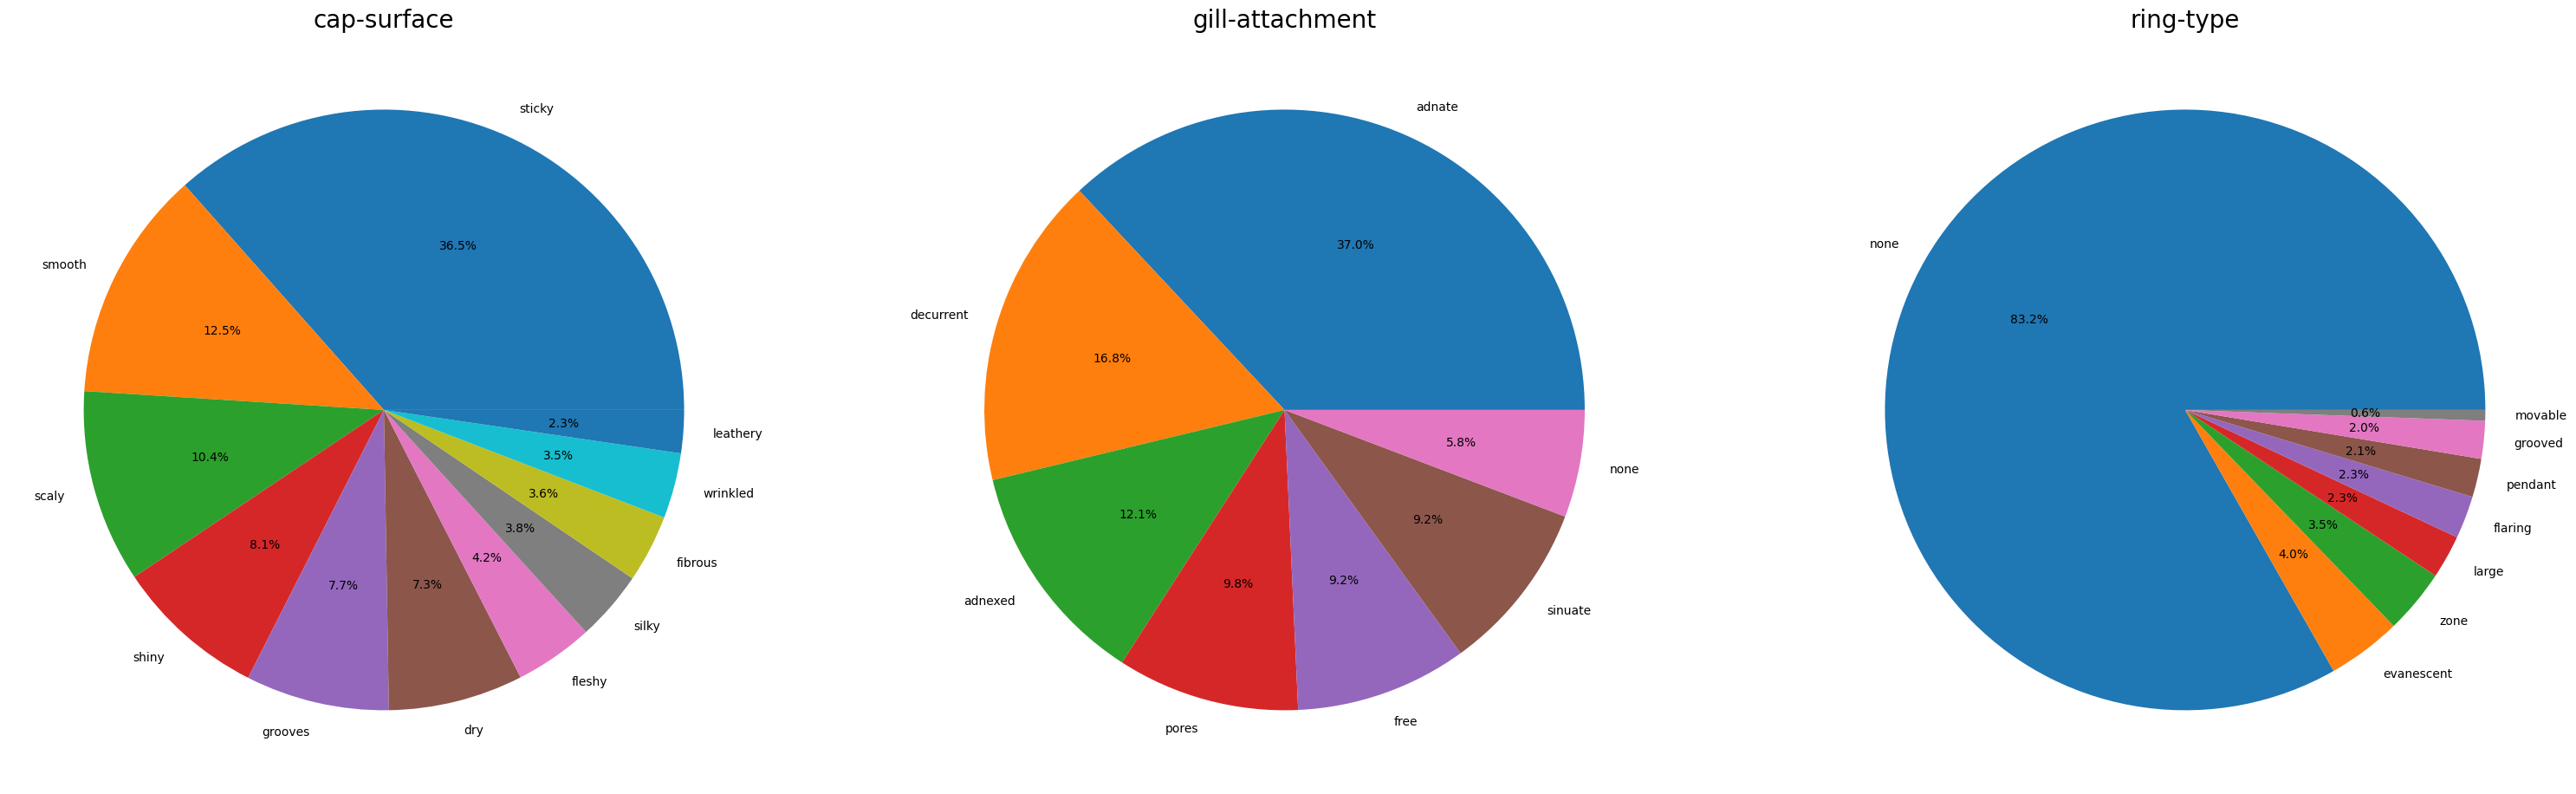

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(38, 15))
y=0
for elem in categorical_cols:
  if elem in nan_list:
    col = df[elem]
    mode = col.mode()
    print('La moda per la colonna', col.name, 'è:', mode.iloc[0])
    df1 = col.fillna(mode.iloc[0], inplace=True)
    percentages = col.value_counts(normalize=True) * 100
    ax = percentages.plot.pie(ax=axes[y], autopct='%1.1f%%')
    ax.set_title(col.name, fontsize=20)
    ax.set_ylabel('')
    y+=1


Il grafico seguente mostra le correlazioni tra le tre classi con valori NaN e il target. Come possiamo vedere, alcune categorie hanno una correlazione con il target abbastanza alta, ovvero hanno una media dei risultati molto spostata verso i positivi o i negativi. Le tre categorie prese come moda però hanno una correlazione abbastanza bassa, con valori di 0.43, 0.37 e 0.45 rispettivamente, quindi sostituire i NaN con la moda non rende il dataset inconsistente.

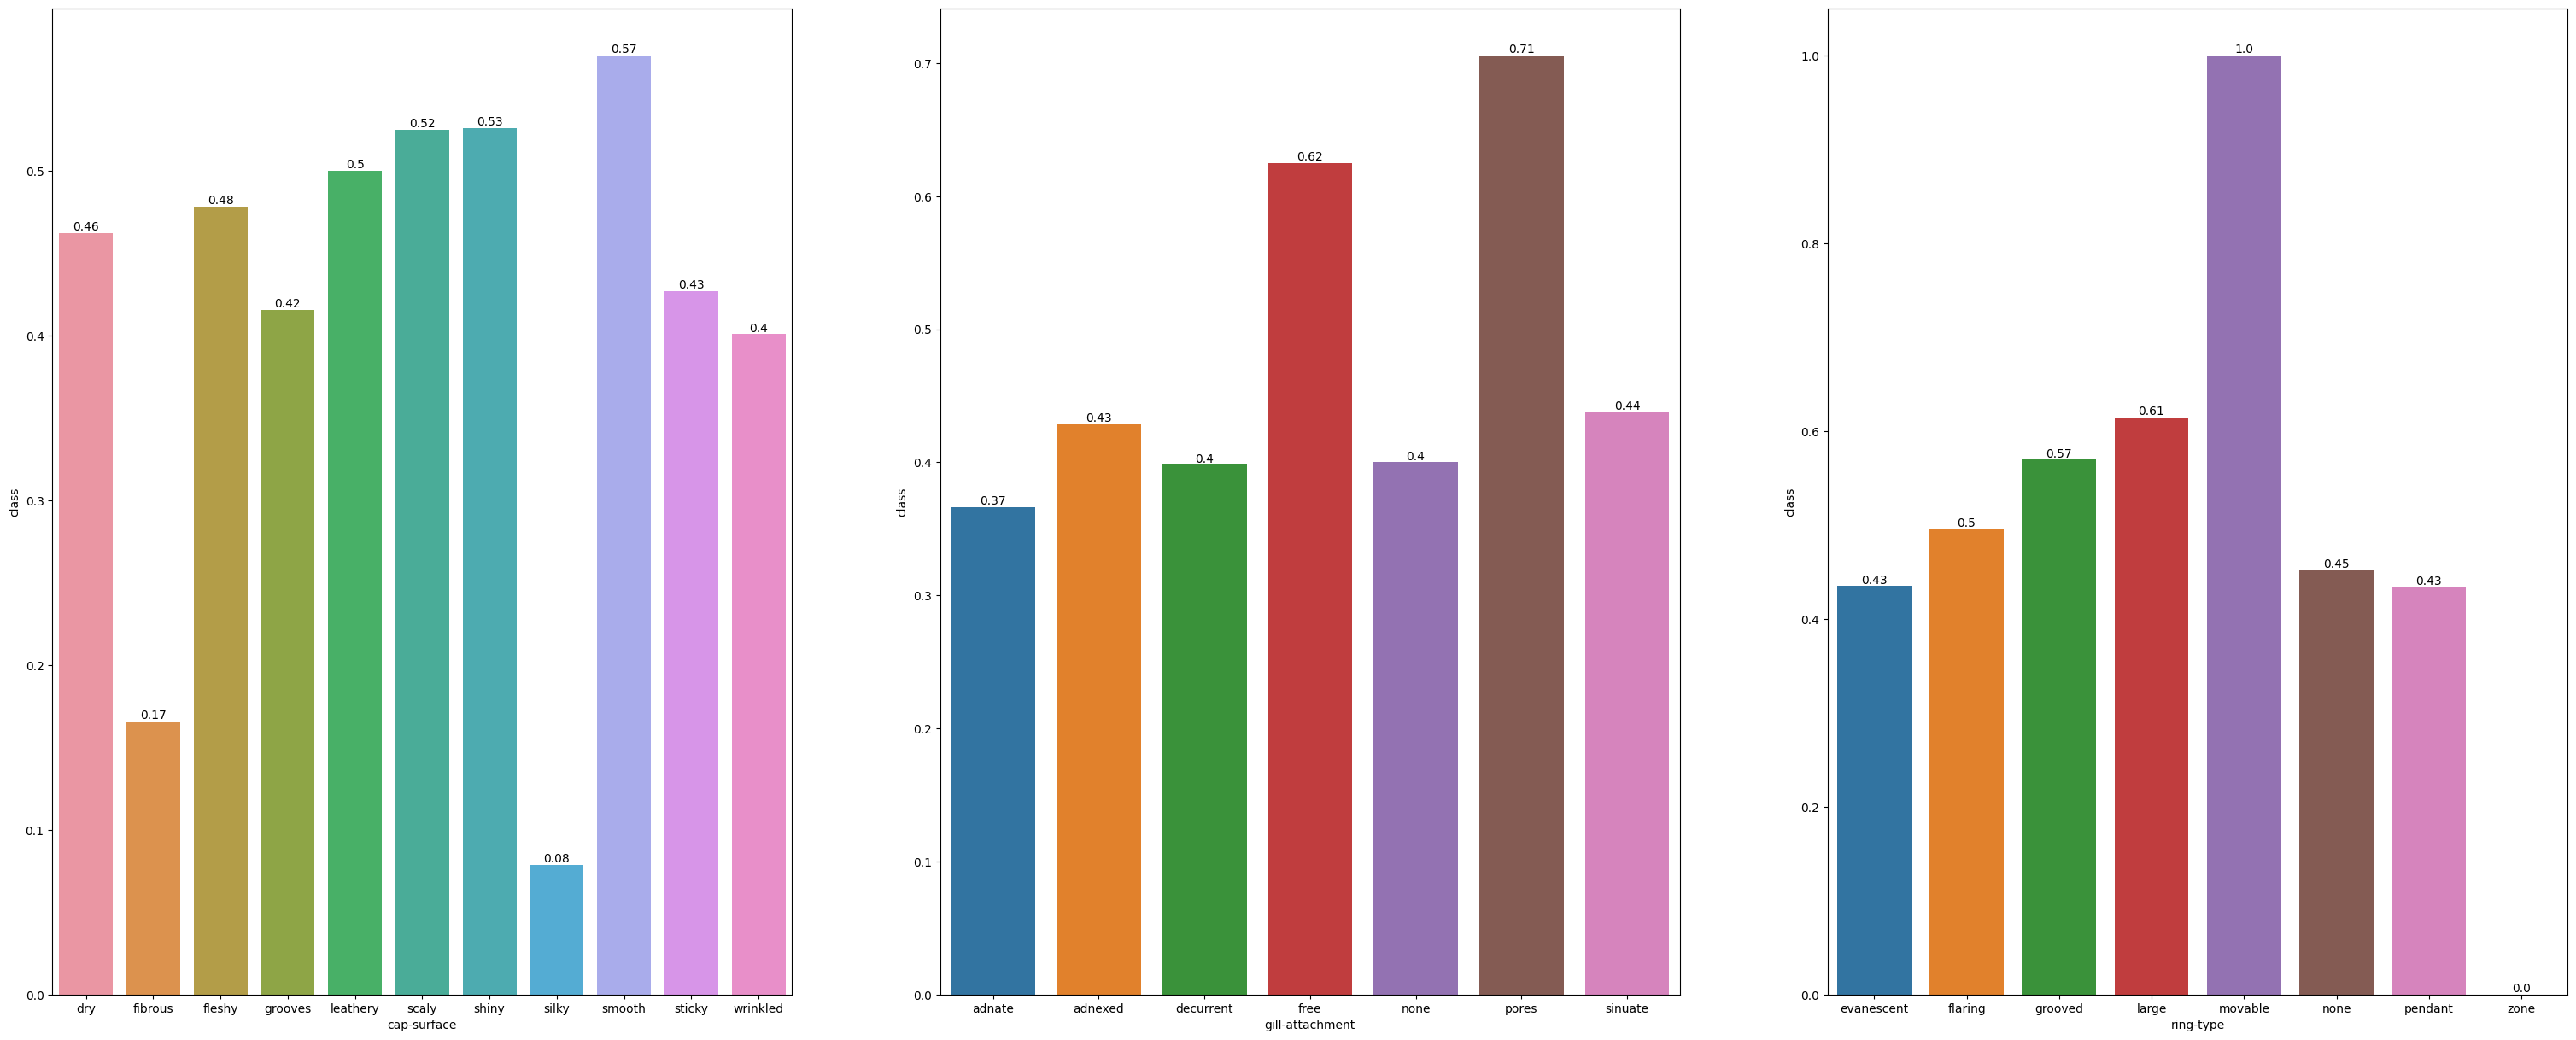

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(38, 15))
y = 0
target = df['class']
for elem in nan_list:
  col = df[elem]
  correlation = df.groupby(col.name)[target.name].mean().reset_index()


  sns.barplot(x=col.name, y=target.name, data=correlation, ax=axes[y])

  for i, val in enumerate(correlation[target.name]):
    axes[y].text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom')

  plt.xlabel(col.name)
  plt.ylabel(target.name)
  y+=1


# Mostra il grafico
plt.show()


L'ultimo controllo da fare è controllare se le classi target sono bilanciate. Come si può vedere sotto abbiamo il 45% delle righe che contengono funghi edibili e il 55% delle righe con funghi velenosi. Abbiamo un leggero sbilanciamento verso i funghi velenosi ma può essere considerato accettabile

In [38]:
target = df['class']
print('Number of edible items: {0:d}'.format(df[target==1].shape[0]))
print('Number of poisonous items: {0:d}'.format(df[target==0].shape[0]))
print('Fraction of edible items: {0:3.2f}'.format(df[target==1].shape[0]/df.shape[0]))

Number of edible items: 27181
Number of poisonous items: 33888
Fraction of edible items: 0.45


### One Hot Encoding
L'ultimo passo nel preprocessamento del nostro dataset è andare a convertire le variabili categoriche che abbiamo in variabili numeriche, per poterle usare in modelli di machine learning. L'encoding one-hot è una tecnica di trasformazione che crea variabili dummy per ogni categoria presente nella variabile categorica. Queste variabili assumeranno il valore 1 se l'osservazione corrisponde alla categoria corrispondente e 0 altrimenti. Questo tipo di encoding viene utilizzato quando non esiste un'ordine intrinseco tra le categorie, come succede in tutte le categorie che dobbiamo convertire. Come si può vedere, dopo aver applicato il one hot encoding, abbiamo 88 colonne nel nostro dataset. Nel dataset con one hot encoding convertiamo anche i booleani in interi, per avere un dataset totalmente numerico.

In [47]:
df_encoded = pd.get_dummies(df, columns=categorical_cols)
for elem in boolean_cols:
  df_encoded[elem] = df_encoded[elem].astype(int)
print("Il nuovo numero di colonne è:",df_encoded.shape[1])

Il nuovo numero di colonne è: 88


## Linear Discriminant Analysis